# Q-Network

Leture 6. Q-Network
- [강의 슬라이드](http://hunkim.github.io/ml/RL/rl06.pdf)
- [강의 동영상](https://www.youtube.com/watch?v=w9GwqPx7LW8)


### Vanilla Q-Learning vs Q-Network

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FclZLp2%2FbtrATdqwjsW%2FLsYcA3Q89jwZlRX2sU0aVk%2Fimg.png" width="400" height="300"/>



### Q-Learning
---
- 큐-러닝 : 에이전트가 주어진 상태에서 행동을 취했을 경우 받을 수 있는 보상의 기댓값을 예측하는 큐-함수(Q-function)를 사용하여 최적화된 정책을 학습하는 강화 학습 기법이다.
- 큐러닝의 한계 : state-action에 따른 값들을 모두 Table 형태(Q-Table)로 구성되므로 에이전트가 취할 수 있는 상태 개수가 많은 경우 큐-테이블 구축에 한계가 발생한다.


### Q-Network 
---

- 신경망을 활용한 Q-learning : 현재 상태를 입력으로 주었을때 취할수 있는 모든 행동에 대한 Q-value를 반환한다.
 <img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fbzdecs%2FbtrAQgIfEpI%2FK4batbxm9BBcugKt6G3Mk1%2Fimg.png" width="400" height="50"/>

 - 결과값은 Linear Regressing(선형회귀)의 결과와 비슷한 Ws로 설정
 - Cost Function(비용함수) : Ws와 Label값인 y의 차를 제곱한 값들을 더한 값으로 설정된다.

<br>

- 비용에 대한 최소화를 공식화

 <img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbjaUIW%2FbtrATS1ksOK%2FkPkiiJT659kvhiPwykckG1%2Fimg.png" width="400" height="150"/>

 - 목표값 : Q*(Optimal Q) = reward + dis * np.max(q_score_next) 
 - 예측값 : Q_hat(Q prediction) = Ws = tf.matmul(one_hot(state), W)


In [ ]:
import os
import time
import gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [ ]:
def one_hot(x):
    return np.identity(16)[x:x+1].astype(np.float32)

In [ ]:
env = gym.make('FrozenLake-v0')

# Set Q-learning parameters
num_episodes = 2000
learning_rate = 0.1
dis = .99

# Input and output size based on the Env
input_size = env.observation_space.n
output_size = env.action_space.n

# weight
W = tf.Variable(tf.random.uniform([input_size, output_size], 0, 0.01), dtype=tf.float32)
# optimizer 
optimizer = tf.optimizers.SGD(learning_rate=learning_rate)

In [ ]:
start_time = time.time()
# rewards per episode
rList = []
for i in range(num_episodes):
    # Reset environment and get first new observation
    state = env.reset()
    rAll = 0
    done = False
    local_loss = []

    e = 1. / ((i / 50) + 10)
    # The Q-Table learning algorithm
    while not done:
        # Choose an action by greedly (with a chance of random action) from the Q-network
        q_value = tf.matmul(one_hot(state), W)  
        q_value = np.array(q_value.numpy())

        if np.random.rand(1) < e:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_value)

        #--------------------------------------------------------------------
        # Set y label
        #--------------------------------------------------------------------
        # Get new state and reward from environment
        state_next, reward, done, _ = env.step(action)
        if done:
            # Update Q, and no q_value+1, since it's action termial state
            q_value[0, action] = reward
        else:
            # Obtain the Q_s` values by feeding the new state through our network
            q_score_next = tf.matmul(one_hot(state_next), W)  
            # Update Q
            q_value[0, action] = reward + dis * np.max(q_score_next) 

        #--------------------------------------------------------------------
        # Train our network using target (Y) and predicted Q(Q_pred) values
        # Q_pred : tf.matmul(one_hot(state), W))
        #--------------------------------------------------------------------
        loss = lambda: tf.reduce_sum(input_tensor=tf.square(q_value - tf.matmul(one_hot(state), W)))

        # optimizer, loss가 작아지는 방향으로 W 업데이트
        optimizer.minimize(loss, var_list=W)
        rAll += reward
        state = state_next
    rList.append(rAll)

220.44312620162964 seconds
Success rate: 0.413


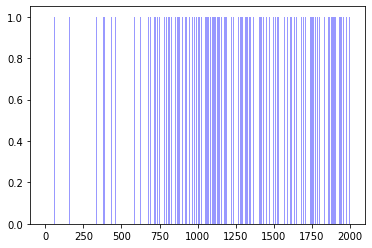

In [ ]:
print(f'{(time.time() - start_time)} seconds')
print("Success rate: " + str(sum(rList) / num_episodes))
plt.bar(range(len(rList)), rList, color='b', alpha=0.4)
plt.show()

## Q-Network 의 한계
Q Network의 결과는 아래의 문제점으로 Q-Table 보다 성능이 좋지 않다.

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FYbJRV%2FbtrAYlueDcJ%2FhPi4stPGEGSZq71LESqYK1%2Fimg.png" width="400" height="300"/>


- Correlation 
 - 연속된 sample들로 학습시 연관성이 커 학습이 되지 않는다.
 - 전체적인 특징을 파악하기 어렵다.
- Non-stationary target 
 - Target값과 예측값을 구하는데 같은 모델을 사용하여 네트워크가 업데이트되면 Target값이 변하게 된다.
 - label에 해당하는 Target값이 변하므로 학습이 안정적으로 이루어지지 않는다.





### Reference
- [Deep Q Network (DQN)](https://engineering-ladder.tistory.com/68?category=826971)